In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pavia-university-hsi/PaviaU_gt.mat
/kaggle/input/pavia-university-hsi/PaviaU.mat
/kaggle/input/1992-indian-pines/Indian_pines_corrected.mat
/kaggle/input/1992-indian-pines/Indian_pines.mat
/kaggle/input/1992-indian-pines/Indian_pines_gt.mat


In [45]:
import numpy as np
from sklearn.decomposition import PCA
import scipy.io as sio
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import os
import random
from random import shuffle
from skimage.transform import rotate
import scipy.ndimage
import matplotlib.pyplot as plt
import scipy
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Conv3D, MaxPooling3D, GlobalAveragePooling3D, Dense, Dropout, Input
from keras.optimizers import SGD
from keras import backend as K
K.set_image_data_format('channels_last')
from keras.utils import to_categorical
from sklearn.decomposition import PCA
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import itertools
from sklearn.metrics import cohen_kappa_score
from matplotlib import colors 

# **EDA**

In [4]:
data_pavia = sio.loadmat('/kaggle/input/pavia-university-hsi/PaviaU.mat')['paviaU']  # Replace with your file path
ground_truth_pavia = sio.loadmat('/kaggle/input/pavia-university-hsi/PaviaU_gt.mat')['paviaU_gt'] # Replace with your file path


In [5]:
print("Pavia University data shape:", data_pavia.shape)
print("Pavia University ground truth shape:", ground_truth_pavia.shape)


Pavia University data shape: (610, 340, 103)
Pavia University ground truth shape: (610, 340)


In [6]:
import numpy as np

def get_dataset_info(dataset_name, dataset, ground_truth):
    print(f"Dataset: {dataset_name}")
    print(f"Dimensions (width, height, bands): {dataset.shape}")
    print(f"Number of Bands: {dataset.shape[2]}")
    print(f"Ground Truth Classes: {np.unique(ground_truth)}")
    print()
    

get_dataset_info('paviaU', data_pavia, ground_truth_pavia)

Dataset: paviaU
Dimensions (width, height, bands): (610, 340, 103)
Number of Bands: 103
Ground Truth Classes: [0 1 2 3 4 5 6 7 8 9]



In [12]:
import pandas as pd
print('paviaU')
# Get unique class names based on ground truth labels for the current dataset
class_names = np.unique(ground_truth_pavia)
# Calculate the number of samples for each class
summary = pd.DataFrame([{'class_name': label, 'samples': np.sum(ground_truth_pavia == val)} for val, label in enumerate(class_names)])
print(summary)
print()

paviaU
   class_name  samples
0           0   164624
1           1     6631
2           2    18649
3           3     2099
4           4     3064
5           5     1345
6           6     5029
7           7     1330
8           8     3682
9           9      947



## Data Visualisation

### Class Distribution

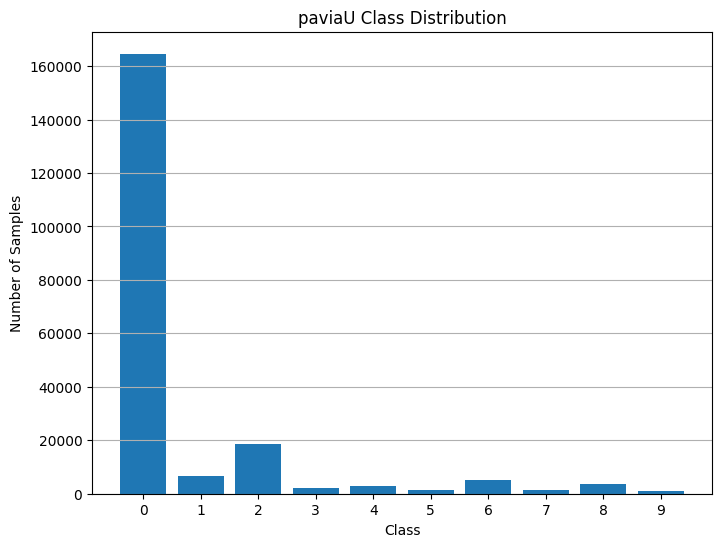

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def plot_class_distribution(data, ground_truth, dataset_name):
    # Compute unique classes and their counts
    unique_classes, class_counts = np.unique(ground_truth, return_counts=True)
    
    # Plot class distribution
    plt.figure(figsize=(8, 6))
    plt.bar(unique_classes, class_counts)
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    plt.title(f'{dataset_name} Class Distribution')
    plt.xticks(unique_classes)
    plt.grid(axis='y')
    plt.show()


plot_class_distribution(data_pavia, ground_truth_pavia, 'paviaU')


### Visualisation of selective bands

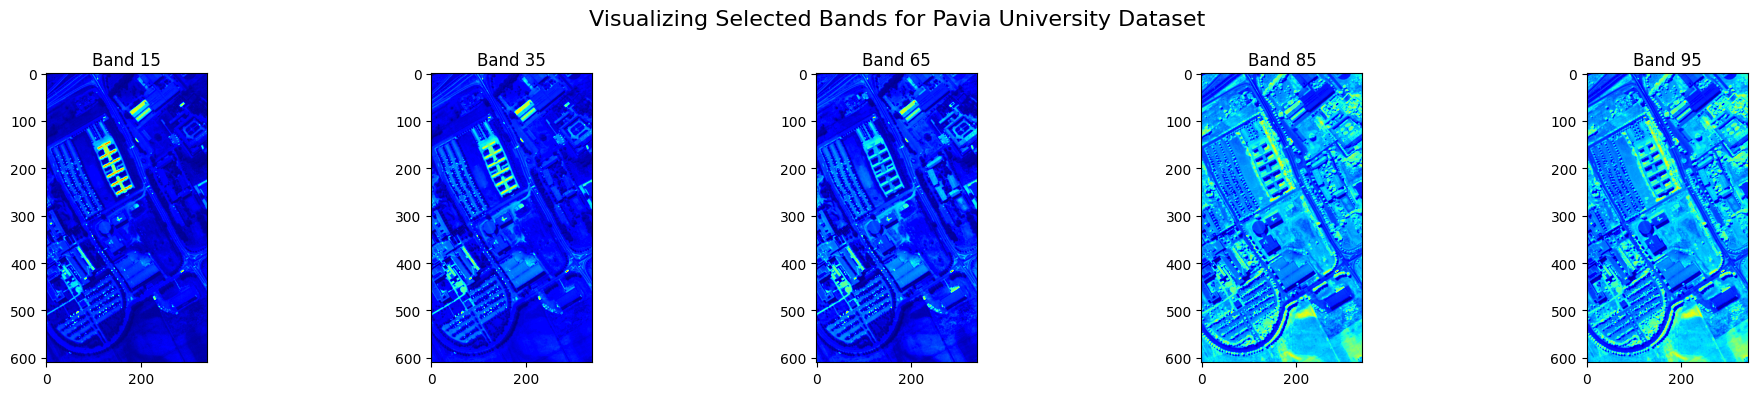

In [13]:
def visualize_selected_bands(dataset_name, dataset, band_indices):
    num_bands_to_visualize = len(band_indices)
    num_plots = num_bands_to_visualize // 5 + (1 if num_bands_to_visualize % 5 != 0 else 0)
    fig, axes = plt.subplots(num_plots, 5, figsize=(20, num_plots * 4))
    fig.suptitle(f'Visualizing Selected Bands for {dataset_name} Dataset', fontsize=16)
    if num_plots == 1:
        axes = [axes]
    for i, band_idx in enumerate(band_indices):
        row_idx = i // 5
        col_idx = i % 5
        axes[row_idx][col_idx].imshow(dataset[:,:,band_idx], cmap='jet')
        axes[row_idx][col_idx].set_title(f'Band {band_idx}')
    plt.tight_layout()
    plt.show()

indian_selected_bands = [15, 35, 65, 85, 95]
pavia_selected_bands = [15, 35, 65, 85, 95]

visualize_selected_bands("Pavia University", data_pavia, pavia_selected_bands)


### RGB Bands

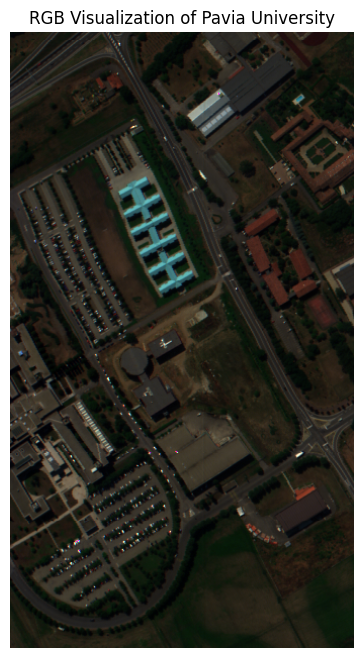

In [14]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

def visualize_rgb(dataset_name, X, bands):
    # Extract the selected RGB bands
    rgb_image = X[:, :, bands]

    # Normalize the bands to [0, 1] for display purposes
    scaler = MinMaxScaler()
    rgb_image = rgb_image.reshape(-1, 3)
    rgb_image = scaler.fit_transform(rgb_image)
    rgb_image = rgb_image.reshape(X.shape[0], X.shape[1], 3)

    # Plot the RGB image
    plt.figure(figsize=(8, 8))
    plt.imshow(rgb_image)
    plt.title(f"RGB Visualization of {dataset_name}")
    plt.axis('off')
    plt.show()

# Bands to use for RGB visualization (these are approximations for visible bands)
# [Red, Green, Blue] bands
rgb_bands_pavia = [60, 30, 10]  # Example for Pavia (103 bands total)
rgb_bands_indian = [60, 30, 10]  # Example for Indian Pines (200 bands total)

# Visualize Pavia University dataset
visualize_rgb("Pavia University", data_pavia, rgb_bands_pavia)



### Ground Truth

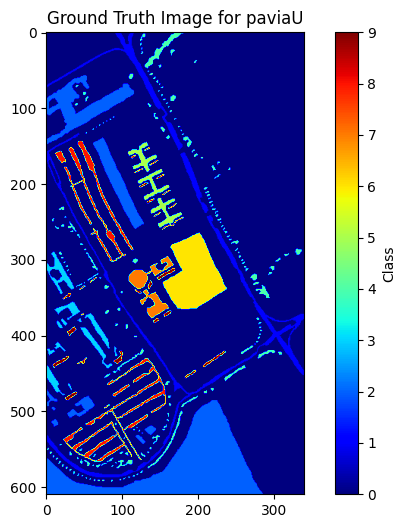

In [15]:
def visualize_ground_truth(dataset_name, ground_truth):
    plt.figure(figsize=(8, 6))
    plt.imshow(ground_truth, cmap='jet')
    plt.title(f'Ground Truth Image for {dataset_name}')
    plt.colorbar(label='Class')
    plt.show()

visualize_ground_truth('paviaU', ground_truth_pavia)

## **Data Preprocessing**


### Normalisation

In [16]:
def normalize_data(raw_data):
    max_value = np.max(raw_data)
    print(max_value)
    min_value = np.min(raw_data)
    print(min_value)
    normalized_data = (raw_data - min_value) / (max_value - min_value)
    return normalized_data

pavia_normalized = normalize_data(data_pavia)


8000
0


### Dimensionality reduction with PCA

In [17]:
from sklearn.decomposition import PCA

def dimension_PCA(data, input_dimension):
    # Reshape the data into a 2D array (samples x features)
    num_samples, num_features, num_bands = data.shape
    flattened_data = data.reshape(num_samples * num_features, num_bands)

    # Apply PCA to the flattened data
    pca = PCA(n_components=input_dimension)
    pca.fit(flattened_data)

    # Transform the data back to the original shape
    transformed_data = pca.transform(flattened_data)
    whole_pca = transformed_data.reshape(num_samples, num_features, input_dimension)

    return whole_pca

pavia_pca = dimension_PCA(pavia_normalized, 10)
print(pavia_pca.shape)


(610, 340, 10)


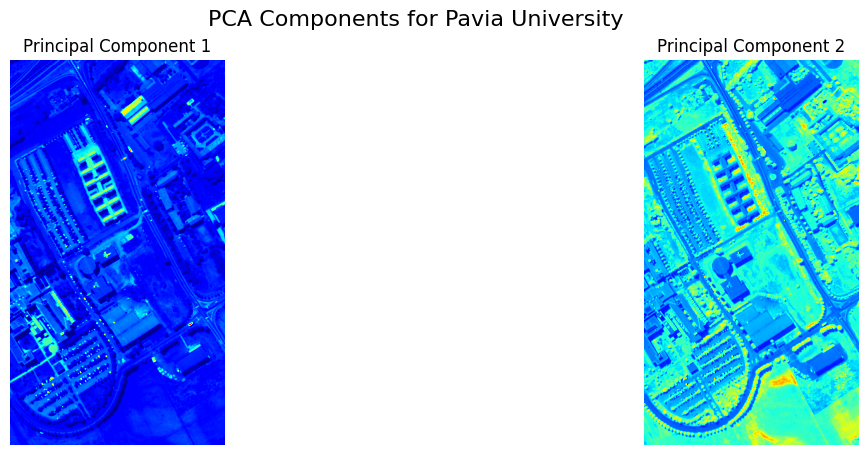

In [18]:
def plot_pca_components(pca_data, dataset_name, num_components=2):
    fig, axes = plt.subplots(1, num_components, figsize=(15, 5))
    for i in range(num_components):
        axes[i].imshow(pca_data[:, :, i], cmap='jet')
        axes[i].set_title(f'Principal Component {i+1}')
        axes[i].axis('off')
    fig.suptitle(f'PCA Components for {dataset_name}', fontsize=16)
    plt.show()

plot_pca_components(pavia_pca, 'Pavia University')


# Classification with 2D CNN

In [89]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

def createPatches(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

windowSize = 5
XPatches, yPatches = createPatches(pavia_pca, ground_truth_pavia, windowSize=windowSize)
print("Pavia University patches shape - X:", XPatches.shape, "y:", yPatches.shape)


Pavia University patches shape - X: (42776, 5, 5, 10) y: (42776,)


In [90]:
# Define test, validation, and train ratios
test_ratio = 0.1
val_ratio = 0.2
train_ratio = 0.7

# First, split into training+validation (90%) and test (10%)
X_train_val, X_test, y_train_val, y_test = train_test_split(XPatches, yPatches, test_size=test_ratio, random_state=345, stratify=yPatches)

# Then, split the remaining 90% into 70% training and 20% validation
val_ratio_adjusted = val_ratio / (train_ratio + val_ratio)  # Adjust validation ratio relative to the 90%
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_ratio_adjusted, random_state=345, stratify=y_train_val)

# Print shapes to confirm the split
print("X_train shape: " + str(X_train.shape))
print("y_train shape: " + str(y_train.shape))
print("X_val shape: " + str(X_val.shape))
print("y_val shape: " + str(y_val.shape))
print("X_test shape: " + str(X_test.shape))
print("y_test shape: " + str(y_test.shape))

X_train shape: (29942, 5, 5, 10)
y_train shape: (29942,)
X_val shape: (8556, 5, 5, 10)
y_val shape: (8556,)
X_test shape: (4278, 5, 5, 10)
y_test shape: (4278,)


In [62]:
# Function to oversample weak classes
def oversampleWeakClasses(X, y):
    uniqueLabels, labelCounts = np.unique(y, return_counts=True)
    maxCount = np.max(labelCounts)
    labelInverseRatios = maxCount / labelCounts
    # Repeat for every label and concatenate
    newX = X[y == uniqueLabels[0], :, :, :].repeat(round(labelInverseRatios[0]), axis=0)
    newY = y[y == uniqueLabels[0]].repeat(round(labelInverseRatios[0]), axis=0)
    for label, labelInverseRatio in zip(uniqueLabels[1:], labelInverseRatios[1:]):
        cX = X[y == label, :, :, :].repeat(round(labelInverseRatio), axis=0)
        cY = y[y == label].repeat(round(labelInverseRatio), axis=0)
        newX = np.concatenate((newX, cX))
        newY = np.concatenate((newY, cY))
    np.random.seed(42)
    rand_perm = np.random.permutation(newY.shape[0])
    newX = newX[rand_perm, :, :, :]
    newY = newY[rand_perm]
    return newX, newY

# Apply oversampling to training data
X_train, y_train = oversampleWeakClasses(X_train, y_train)

In [91]:
# Data augmentation function
def AugmentData(X_train):
    for i in range(int(X_train.shape[0] / 2)):
        patch = X_train[i, :, :, :]
        num = random.randint(0, 2)
        if num == 0:
            flipped_patch = np.flipud(patch)
        elif num == 1:
            flipped_patch = np.fliplr(patch)
        elif num == 2:
            no = random.randrange(-180, 180, 30)
            flipped_patch = scipy.ndimage.interpolation.rotate(patch, no, axes=(1, 0), reshape=False, order=3, mode='constant', cval=0.0, prefilter=False)
        X_train[i, :, :, :] = flipped_patch
    return X_train

# Apply data augmentation to training data
X_train = AugmentData(X_train)

/tmp/ipykernel_30/2895882191.py:12: DeprecationWarning: Please import `rotate` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  flipped_patch = scipy.ndimage.interpolation.rotate(patch, no, axes=(1, 0), reshape=False, order=3, mode='constant', cval=0.0, prefilter=False)


In [92]:
# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=9)
y_val = to_categorical(y_val, num_classes=9)
y_test = to_categorical(y_test, num_classes=9)

In [37]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# Model architecture with L2 regularization
model = Sequential()
model.add(Conv2D(30, (3, 3), activation='relu', input_shape=X_train.shape[1:], kernel_regularizer=l2(0.001)))
model.add(Conv2D(90, (3, 3), activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(60, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(9, activation='softmax'))  # Adjust to your number of classes


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [38]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # You can also monitor 'val_accuracy' if needed
    patience=3,          # Number of epochs with no improvement after which training will stop
    restore_best_weights=True  # Restores model weights from the best epoch with the lowest validation loss
)

# Fit the model with training data, validation data, and early stopping
history = model.fit(X_train, y_train, 
                    batch_size=32, 
                    epochs=16, 
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping])


Epoch 1/16
3735/3735 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.8086 - loss: 0.6312 - val_accuracy: 0.9701 - val_loss: 0.2121
Epoch 2/16
3735/3735 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9520 - loss: 0.2566 - val_accuracy: 0.9704 - val_loss: 0.1879
Epoch 3/16
3735/3735 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9603 - loss: 0.2175 - val_accuracy: 0.9769 - val_loss: 0.1635
Epoch 4/16
3735/3735 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9629 - loss: 0.2010 - val_accuracy: 0.9774 - val_loss: 0.1512
Epoch 5/16
3735/3735 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9660 - loss: 0.1890 - val_accuracy: 0.9792 - val_loss: 0.1408
Epoch 6/16
3735/3735 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9664 - loss: 0.1830 - val_accuracy: 0.9839 - val_loss: 0.1312
Epoch 7/16
3735/3735 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9685 - loss: 0.1757 - val_accuracy: 0.9866 - val_loss: 0.1243
Epoch 8/16
3735/3735 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9695 - loss: 0.1720 -

### Model Evaluation

In [42]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)

# Predict the class labels for the test set
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)  # Convert probabilities to class labels
y_true = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels to class labels

# Calculate Cohen's Kappa
kappa = cohen_kappa_score(y_true, y_pred)

# Print the results
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")


134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9809 - loss: 0.1305
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Test Loss: 0.1294
Test Accuracy: 0.9825
Cohen's Kappa: 0.9768


In [32]:
import h5py
from keras.models import load_model
model.save("/kaggle/working/paviaU_New_2DCNN/model.h5")

134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


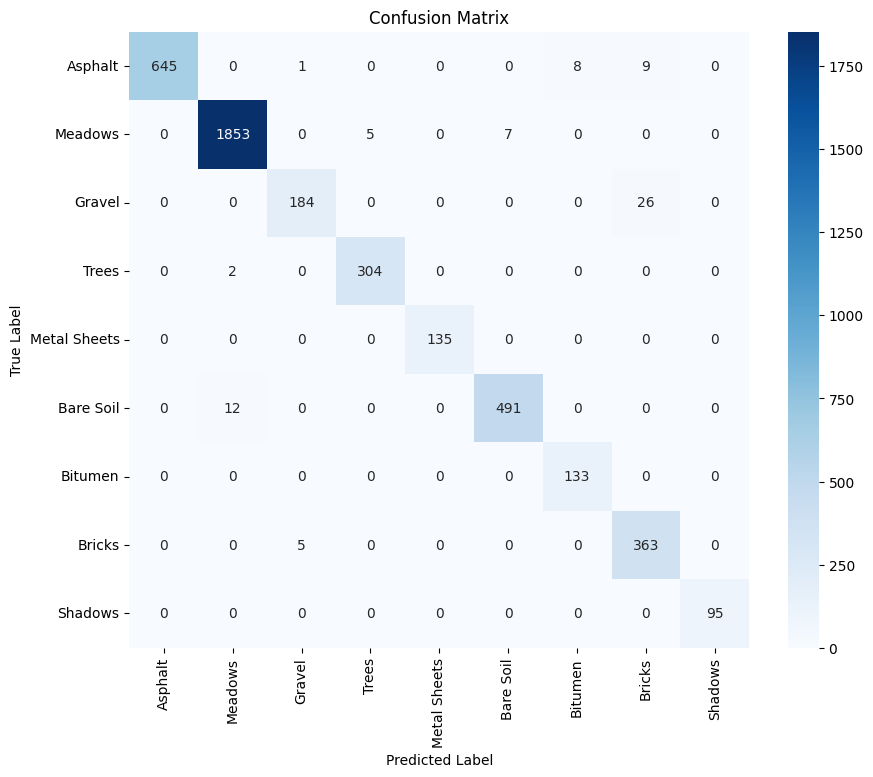

              precision    recall  f1-score   support

     Asphalt       1.00      0.97      0.99       663
     Meadows       0.99      0.99      0.99      1865
      Gravel       0.97      0.88      0.92       210
       Trees       0.98      0.99      0.99       306
Metal Sheets       1.00      1.00      1.00       135
   Bare Soil       0.99      0.98      0.98       503
     Bitumen       0.94      1.00      0.97       133
      Bricks       0.91      0.99      0.95       368
     Shadows       1.00      1.00      1.00        95

    accuracy                           0.98      4278
   macro avg       0.98      0.98      0.98      4278
weighted avg       0.98      0.98      0.98      4278



In [40]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Make predictions on the test set
y_pred = model.predict(X_test)

# Convert predictions to class labels
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Create confusion matrix
conf_matrix = confusion_matrix(y_test_labels, y_pred_labels)

target_names = ['Asphalt', 'Meadows', 'Gravel', 'Trees', 'Metal Sheets', 
                    'Bare Soil', 'Bitumen', 'Bricks', 'Shadows'] 
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Generate classification report
class_report = classification_report(y_test_labels, y_pred_labels, target_names=target_names)
print(class_report)

1337/1337 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


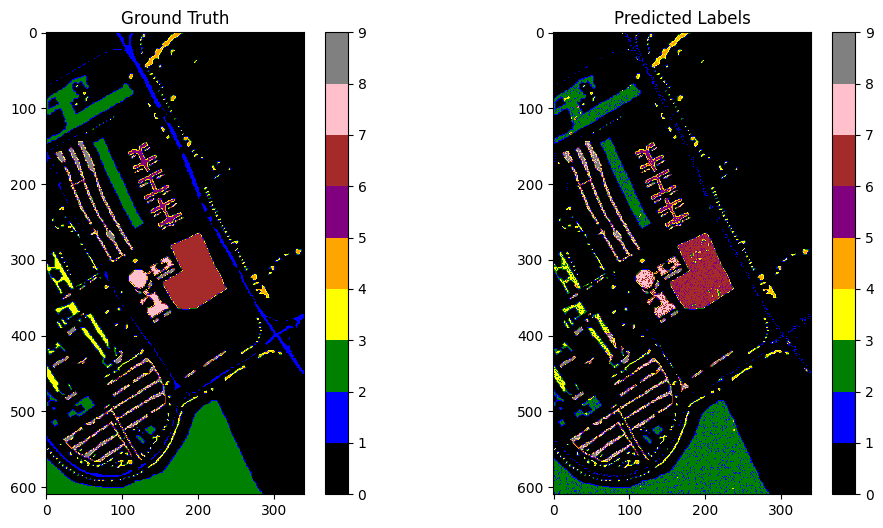

In [41]:
def predict_and_visualize_full_data(model, X_patches, ground_truth_pavia, windowSize):
    # Predict the labels for all patches in the dataset (full image)
    y_pred = model.predict(X_patches)
    y_pred_labels = np.argmax(y_pred, axis=1)

    # Get the indices where the ground truth has valid labels (> 0)
    valid_idx = np.where(ground_truth_pavia > 0)

    # Initialize an empty image to store the predicted labels for the full dataset
    pred_img = np.zeros(ground_truth_pavia.shape)
    
    # Check if the number of predicted patches matches the number of valid pixels in the ground truth
    if len(y_pred_labels) != len(valid_idx[0]):
        raise ValueError(f"Mismatch between predicted patches ({len(y_pred_labels)}) and valid ground truth pixels ({len(valid_idx[0])}).")

    # Assign the predicted labels to the corresponding valid pixels in the full image
    pred_img[valid_idx] = y_pred_labels + 1  # Add 1 to match the ground truth labels

    # Define a color map for visualization
    cmap = colors.ListedColormap(['black', 'blue', 'green', 'yellow', 'orange', 'purple', 'brown', 'pink', 'gray'])
    bounds = np.arange(10)  # Adjust based on the number of classes
    norm = colors.BoundaryNorm(bounds, cmap.N)
    
    # Plot ground truth and predictions side by side
    plt.figure(figsize=(12, 6))
    
    # Ground truth
    plt.subplot(1, 2, 1)
    plt.imshow(ground_truth_pavia, cmap=cmap, norm=norm)
    plt.title('Ground Truth')
    plt.colorbar()
    
    # Predictions
    plt.subplot(1, 2, 2)
    plt.imshow(pred_img, cmap=cmap, norm=norm)
    plt.title('Predicted Labels')
    plt.colorbar()
    
    plt.show()

# Now call this function using the full set of patches (XPatches)
predict_and_visualize_full_data(model, XPatches, ground_truth_pavia, windowSize)


## 3D-CNN

In [51]:
#  Reshape your patches to fit the 3D CNN input shape: (window_size, window_size, num_bands, 1)
X_train_3d = X_train.reshape(-1, windowSize, windowSize, X_train.shape[-1], 1)
X_val_3d = X_val.reshape(-1, windowSize, windowSize, X_val.shape[-1], 1)
X_test_3d = X_test.reshape(-1, windowSize, windowSize, X_test.shape[-1], 1)

In [66]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# Define the 3D CNN model with L2 regularization
model_3d = Sequential()

# 1st 3D Conv layer with L2 regularization and smaller kernel size
model_3d.add(Conv3D(filters=32, kernel_size=(2, 2, 2), activation='relu', kernel_regularizer=l2(0.001), input_shape=(windowSize, windowSize, X_train.shape[-1], 1)))
model_3d.add(MaxPooling3D(pool_size=(2, 2, 1)))  # Reduce pooling depth

# 2nd 3D Conv layer with L2 regularization and smaller kernel size
model_3d.add(Conv3D(filters=64, kernel_size=(2, 2, 2), activation='relu', kernel_regularizer=l2(0.001)))

# Global average pooling to reduce dimensions without further convolution
model_3d.add(GlobalAveragePooling3D())

# Fully connected layers with L2 regularization
model_3d.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
model_3d.add(Dropout(0.5))  # Dropout to prevent overfitting
model_3d.add(Dense(9, activation='softmax'))  # 9 classes for classification

model_3d.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_6 (Conv3D)               │ (None, 4, 4, 9, 32)    │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 2, 2, 9, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_7 (Conv3D)               │ (None, 1, 1, 8, 64)    │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling3d_2      │ (None, 64)             │             0 │
│ (GlobalAveragePooling3D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,217 (102.41 KB)

 Trainable params: 26,217 (102.41 KB)

 Non-trainable params: 0 (0.00 B)

In [67]:
# Compile the 3D CNN model
model_3d.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fit the model with training data, validation data, and early stopping
history = model_3d.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/50
3735/3735 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.7222 - loss: 0.8126 - val_accuracy: 0.8283 - val_loss: 0.4893
Epoch 2/50
3735/3735 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.8826 - loss: 0.4233 - val_accuracy: 0.8903 - val_loss: 0.3790
Epoch 3/50
3735/3735 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9041 - loss: 0.3668 - val_accuracy: 0.9331 - val_loss: 0.3002
Epoch 4/50
3735/3735 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9176 - loss: 0.3308 - val_accuracy: 0.9336 - val_loss: 0.2889
Epoch 5/50
3735/3735 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9294 - loss: 0.3030 - val_accuracy: 0.9139 - val_loss: 0.3104
Epoch 6/50
3735/3735 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9341 - loss: 0.2853 - val_accuracy: 0.9516 - val_loss: 0.2520
Epoch 7/50
3735/3735 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9385 - loss: 0.2710 - val_accuracy: 0.9582 - val_loss: 0.2244
Epoch 8/50
3735/3735 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9430 - loss: 0.2569 -

In [74]:
from sklearn.metrics import cohen_kappa_score

# Evaluate the model
# Make predictions on the test set
y_pred_3d = model_3d.predict(X_test)
y_pred_labels_3d = np.argmax(y_pred_3d, axis=1)  # Take argmax to get the predicted class

test_loss_3d, test_acc_3d = model_3d.evaluate(X_test, y_test)

print(f"Test Accuracy: {test_acc_3d}")
print(f"Test Loss: {test_loss_3d:.4f}")

# Calculate Kappa
kappa_3d = cohen_kappa_score(y_test_labels, y_pred_labels_3d)
print(f"Cohen's Kappa: {kappa_3d:.4f}")

134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9686 - loss: 0.1628
Test Accuracy: 0.9710144996643066
Test Loss: 0.1591
Cohen's Kappa: 0.9616


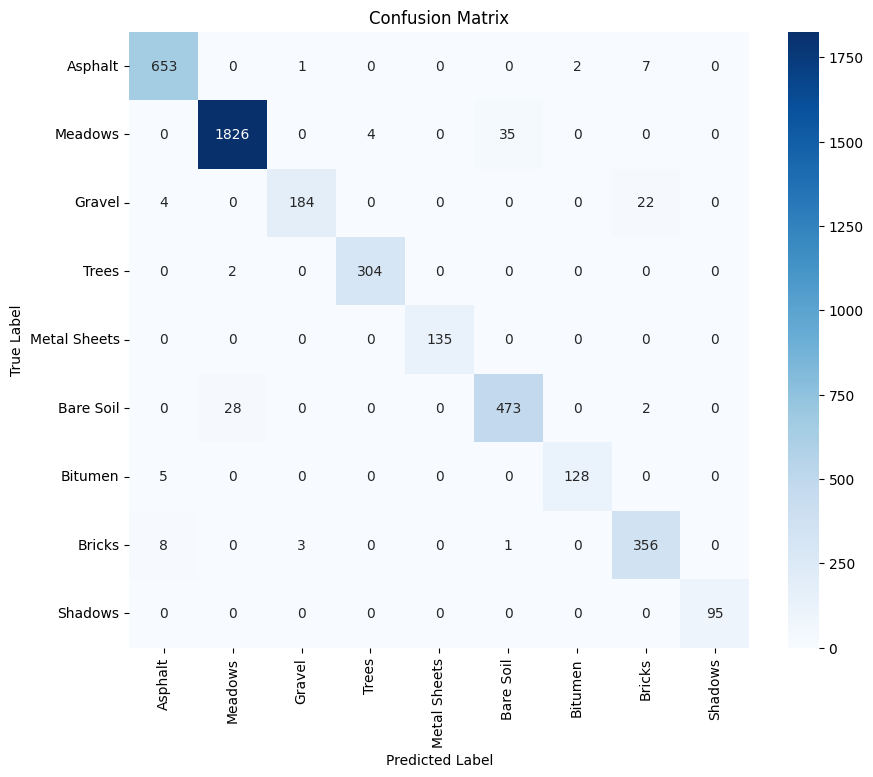

              precision    recall  f1-score   support

     Asphalt       0.97      0.98      0.98       663
     Meadows       0.98      0.98      0.98      1865
      Gravel       0.98      0.88      0.92       210
       Trees       0.99      0.99      0.99       306
Metal Sheets       1.00      1.00      1.00       135
   Bare Soil       0.93      0.94      0.93       503
     Bitumen       0.98      0.96      0.97       133
      Bricks       0.92      0.97      0.94       368
     Shadows       1.00      1.00      1.00        95

    accuracy                           0.97      4278
   macro avg       0.97      0.97      0.97      4278
weighted avg       0.97      0.97      0.97      4278



In [75]:

# If your ground truth labels are one-hot encoded, convert them to class labels
y_test_labels = np.argmax(y_test, axis=1)  # Use this if y_test is one-hot encoded

# Create confusion matrix
conf_matrix = confusion_matrix(y_test_labels, y_pred_labels_3d)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Generate classification report
class_report_3d = classification_report(y_test_labels, y_pred_labels_3d, target_names=target_names)
print(class_report_3d)




1337/1337 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


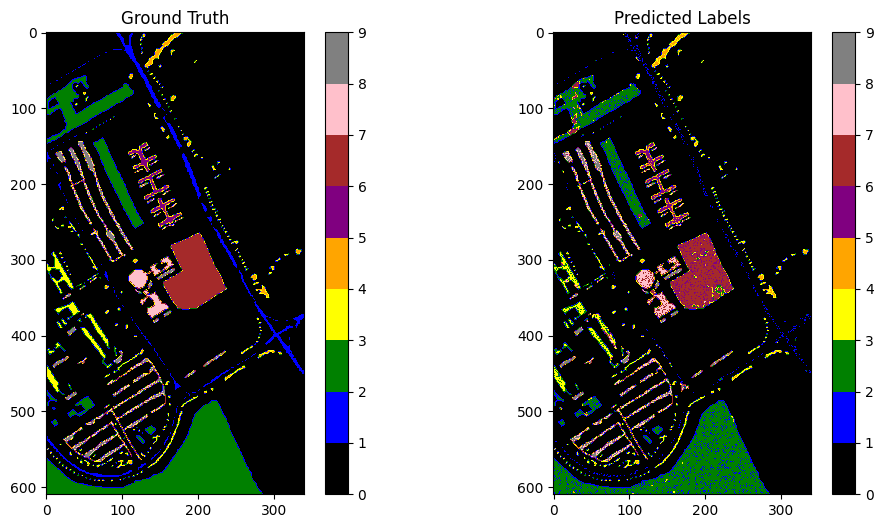

In [78]:

# Visualize predictions using the previous prediction and visualization function
predict_and_visualize_full_data(model_3d, XPatches, ground_truth_pavia, windowSize)


## **RPNet**

In [87]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, MaxPooling2D, GlobalAveragePooling2D, Dense, Concatenate, UpSampling2D, Resizing
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

def residual_block(x, filters, kernel_size=3, stride=1):
    residual = x
    x = Conv2D(filters, kernel_size=kernel_size, strides=stride, padding='same', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(filters, kernel_size=kernel_size, strides=stride, padding='same', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Concatenate()([x, residual])
    x = ReLU()(x)
    return x

def pyramid_pooling_module(x, bin_sizes):
    features = [x]
    input_shape = x.shape[1:3]
    for bin_size in bin_sizes:
        if input_shape[0] >= bin_size and input_shape[1] >= bin_size:
            pooled = MaxPooling2D(pool_size=(bin_size, bin_size), strides=(bin_size, bin_size))(x)
            pooled = Conv2D(256, (1, 1), padding='same', kernel_regularizer=l2(0.001))(pooled)
            pooled = UpSampling2D(size=(input_shape[0] // pooled.shape[1], input_shape[1] // pooled.shape[2]))(pooled)
            pooled = Resizing(input_shape[0], input_shape[1])(pooled)  # Resize to match input shape
            features.append(pooled)
        else:
            print(f"Skipping bin_size {bin_size} due to small dimensions.")
    
    # Concatenate the features
    if len(features) > 1:
        x = Concatenate(axis=-1)(features)
        print(f"After Concatenate: {x.shape}")
    return x

def rpnet(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    # Initial convolution with L2 regularization
    x = Conv2D(64, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.001))(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Residual blocks
    x = residual_block(x, 64)
    x = residual_block(x, 128)
    
    # Pyramid pooling
    x = pyramid_pooling_module(x, bin_sizes=[1, 2, 4, 8])
    
    # Final layers
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, x)
    return model


In [96]:
# Example of using the model with early stopping
input_shape = (windowSize, windowSize, X_train.shape[-1])  # Adjust based on your dataset
num_classes = 9  # Adjust based on your number of classes
model_rpnet = rpnet(input_shape, num_classes)

# Compile the model
model_rpnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Assuming X_train, y_train, X_val, y_val are defined
history = model_rpnet.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_val, y_val), callbacks=[early_stopping])


Skipping bin_size 8 due to small dimensions.
After Concatenate: (None, 5, 5, 1024)
Epoch 1/50
936/936 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - accuracy: 0.8542 - loss: 1.5258 - val_accuracy: 0.9746 - val_loss: 0.3891
Epoch 2/50
936/936 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9530 - loss: 0.3740 - val_accuracy: 0.9773 - val_loss: 0.1985
Epoch 3/50
936/936 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9628 - loss: 0.2280 - val_accuracy: 0.9818 - val_loss: 0.1605
Epoch 4/50
936/936 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9646 - loss: 0.2086 - val_accuracy: 0.9829 - val_loss: 0.1498
Epoch 5/50
936/936 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9706 - loss: 0.1790 - val_accuracy: 0.9735 - val_loss: 0.1838
Epoch 6/50
936/936 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9689 - loss: 0.1890 - val_accuracy: 0.9817 - val_loss: 0.1332
Epoch 7/50
936/936 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9741 - loss: 0.1623 - val_accuracy: 0.9839 - val_loss: 0.1271
Epoch 8/50
936/936 

In [97]:
# Evaluate the model
test_loss_rpnet, test_acc_rpnet = model_rpnet.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc_rpnet}")
print(f"Test Loss: {test_loss_rpnet}")

134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9932 - loss: 0.0968
Test Accuracy: 0.9934548735618591
Test Loss: 0.0864337608218193


134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       663
           1       1.00      1.00      1.00      1865
           2       1.00      0.90      0.95       210
           3       0.99      0.99      0.99       306
           4       0.99      1.00      0.99       135
           5       1.00      1.00      1.00       503
           6       1.00      0.98      0.99       133
           7       0.95      1.00      0.97       368
           8       1.00      1.00      1.00        95

    accuracy                           0.99      4278
   macro avg       0.99      0.99      0.99      4278
weighted avg       0.99      0.99      0.99      4278



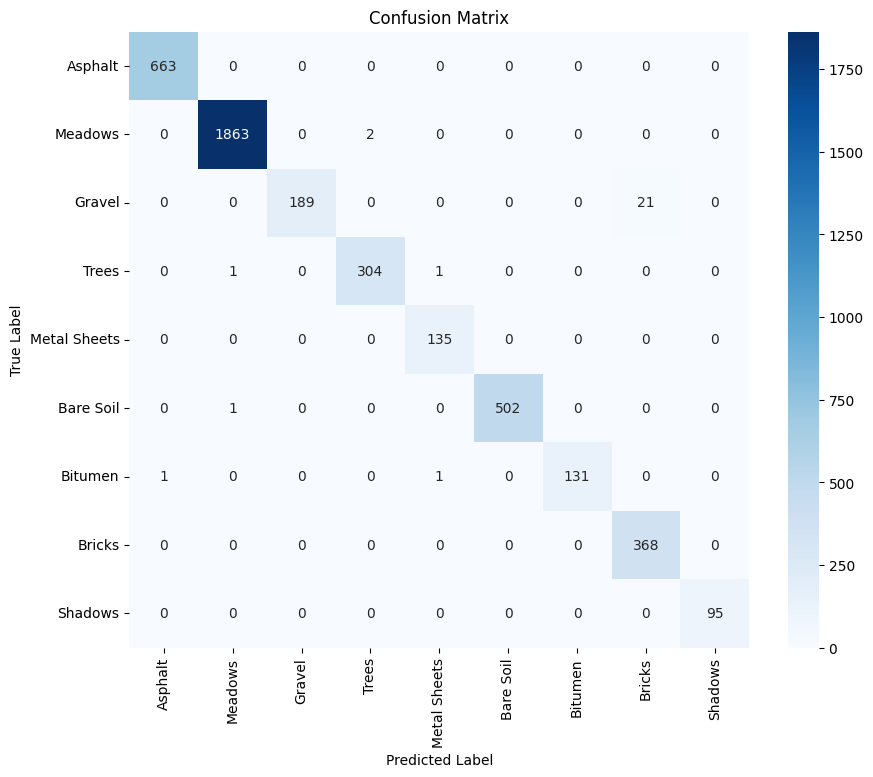

Cohen's Kappa: 0.9913


In [98]:
# Make predictions
y_pred = model_rpnet.predict(X_test)

# Convert predictions from one-hot encoding (if applicable)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)  # Assuming y_test is also one-hot encoded

# Generate confusion matrix
conf_matrix_rpnet = confusion_matrix(y_true, y_pred_classes)


# Generate classification report
class_report = classification_report(y_true, y_pred_classes)
print("Classification Report:")
print(class_report)


# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_rpnet, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Calculate Kappa
kappa = cohen_kappa_score(y_test_labels, y_pred_classes)
print(f"Cohen's Kappa: {kappa:.4f}")


1337/1337 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


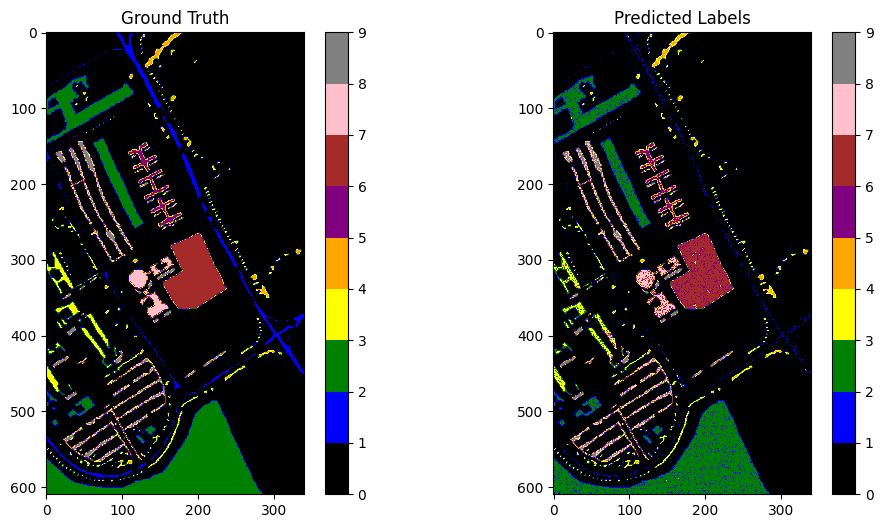

In [99]:
# Predictions and visualization (adjust function as needed)
predict_and_visualize_full_data(model_rpnet, XPatches, ground_truth_pavia, windowSize)

## RPNet-RF

In [103]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.models import Model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np

# Define the RPNet model without the final classification layer (for feature extraction)
def rpnet_feature_extractor(input_shape):
    inputs = Input(shape=input_shape)
    
    # Initial convolution
    x = Conv2D(64, kernel_size=(3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Residual blocks
    x = residual_block(x, 64)
    x = residual_block(x, 128)
    
    # Global average pooling to extract features
    x = GlobalAveragePooling2D()(x)

    # Create the feature extraction model
    model = Model(inputs, x)
    return model

# Define the residual block function
def residual_block(x, filters, kernel_size=3, stride=1):
    residual = x
    x = Conv2D(filters, kernel_size=kernel_size, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(filters, kernel_size=kernel_size, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = Concatenate()([x, residual])
    x = ReLU()(x)
    return x

# Set input shape based on your data: (5, 5, 10)
input_shape = (5, 5, 10)

# Create RPNet feature extractor
model_rpnet = rpnet_feature_extractor(input_shape)

# No need to compile the model since we are not training it for classification
# Just directly use the model to extract features from X_train and X_val

# Step 1: Extract features using the RPNet model
X_train_features = model_rpnet.predict(X_train)
X_val_features = model_rpnet.predict(X_val)

# Step 2: Train the Random Forest classifier on the extracted features
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_features, np.argmax(y_train, axis=1))  # Convert y_train to class labels if needed

# Step 3: Evaluate Random Forest on validation set
y_val_pred = rf_classifier.predict(X_val_features)
val_accuracy = accuracy_score(np.argmax(y_val, axis=1), y_val_pred)

print(f"Validation Accuracy of RPNet_RF: {val_accuracy * 100:.2f}%")


936/936 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Validation Accuracy of RPNet_RF: 96.86%
